In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchvision import datasets as dset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

### Generator

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*4),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim*2, hidden_dim),
            self.gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)
        )

    def gen_block(self, in_channel, out_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        result = self.gen(x)
        return result

### Discriminator

In [3]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(im_chan, hidden_dim),
            self.disc_block(hidden_dim, hidden_dim*2),
            self.disc_block(hidden_dim*2, 1, final_layer=True)
        )
    
    def disc_block(self, in_channel, out_channel, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size, stride),
                # nn.BatchNorm2d(output_channels),
                nn.BatchNorm2d(out_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:  # Final Layer
            return nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

### noise

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

### hyper parameters setting

In [5]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
lr = 2e-4

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

### Data loading

In [6]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size = batch_size,
    shuffle = True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Optimizer

In [7]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## Image Display

In [8]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Training

In [9]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        # Update disc
        disc_opt.zero_grad()
        latent = get_noise(cur_batch_size, z_dim, device=device) # z
        fake = gen(latent) # G(z)
        disc_fake_pred = disc(fake.detach()) # D(G(z)) , detach : 미분 X
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))  # log(1-D(G(z)))
        disc_real_pred = disc(real)  # D(x)
        disc_real_loss =  criterion(disc_real_pred, torch.ones_like(disc_real_pred))  # log(D(x))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # track the average disc loss
        mean_discriminator_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Update gen
        gen_opt.zero_grad()
        latent_2 = get_noise(cur_batch_size, z_dim, device=device) # z
        fake_2 = gen(latent_2) # G(z)
        disc_fake_pred = disc(fake_2) # D(G(z))
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))  # log(1-D(G(z)))
        gen_loss.backward()
        gen_opt.step()

        # Track the average gen loss
        mean_generator_loss += gen_loss.item() / display_step

        # Visualize the results
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"step {cur_step}: Generator loss : {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
            
        cur_step += 1

Output hidden; open in https://colab.research.google.com to view.

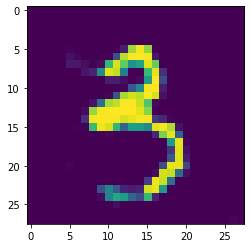

In [11]:
latent = get_noise(cur_batch_size, z_dim, device=device) # z
fake = gen(latent)
plt.imshow(fake.data.cpu().numpy()[0][0])